# ANALYSIS

In [1]:
import numpy as np
import pandas as pd
data=pd.read_pickle('data.pkl')
valid_data=pd.read_pickle('valid_data.pkl')
rate_data=pd.read_pickle('rate_data.pkl')

import matplotlib.pyplot as plt
%matplotlib inline

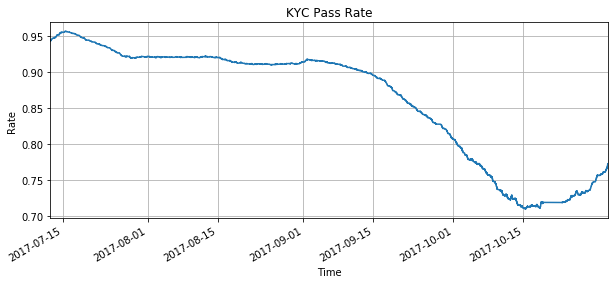

In [43]:
plt.figure()

rate_data['filtered_pass_rate'].plot(figsize=(10,4), grid= True)
plt.xlabel("Time")
plt.ylabel("Rate")
plt.title('KYC Pass Rate')
plt.savefig('fig1.png')




#### The KYC process depends on two categories: Facial and Document.  Both needs to be cleared for the overall result to be cleared. 

#### We will first try to identify wether the decrease is due to facial check, document check or both


<Figure size 432x288 with 0 Axes>

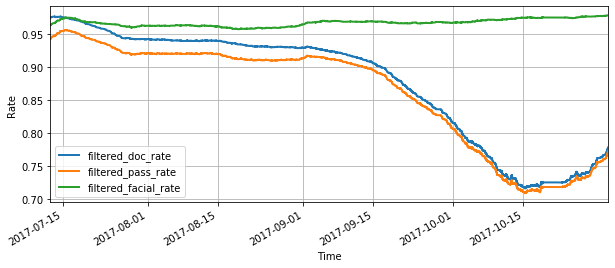

In [44]:
plt.figure()
rate_data[['filtered_doc_rate','filtered_pass_rate','filtered_facial_rate']].plot(figsize=(10,4),grid=True,
lw=2, markersize=10)
plt.xlabel("Time")
plt.ylabel("Rate")
plt.savefig('fig2.png')


#### It seems clear that the decrease in overal pass rate is due to a decrease in document pass rate as the facial similarity pass rate is relatively constant (even slightly increasing). There is a 0.99 correlation coefficient between the doc rate and the pass rate.

#### We can take a look at the sub_result feature that gives a more detailed result for the doc check. Below are the different outputs of the subresult features:
- Clear: if all underlying verifications pass
- Rejected: If the report has returned information where the check cannot be processed further (poor quality image or an unsupported document).
- Suspected: If the document that is analysed is suspected to be fraudulent.
- Caution: If any other underlying verifications fail but they don’t necessarily point to a fraudulent document (such as the name provided by the applicant doesn’t match the one on the document)




<Figure size 432x288 with 0 Axes>

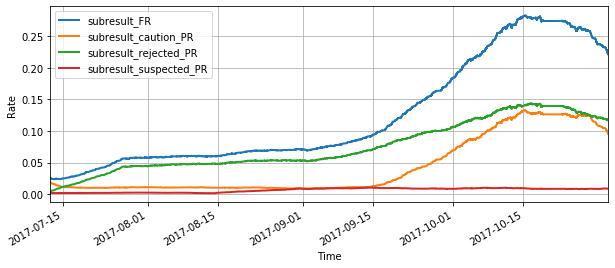

In [48]:
plt.figure()
rate_data['subresult_FR']=1-rate_data.subresult_clear_PR
rate_data[['subresult_FR','subresult_caution_PR','subresult_rejected_PR','subresult_suspected_PR']].plot(figsize=(10,4),grid=True,
lw=2, markersize=10)
plt.xlabel("Time")
plt.ylabel("Rate")
plt.savefig('fig3.png')



#### We see that increase in failure rate is first due to an increase in 'rejected' (end of July) and then due to an increase in 'suspected' (september).


#### We can look at the subcategories involved in the document check to better understand what happened at these 2 dates


#### Here are the different categories involved in the document check: 
   - Police record : Asserts whether the document has been identified as lost, stolen or otherwise compromised
   - Data comparison: Asserts whether data on the document is consistent with data provided by an applicant (either through Veritas’s applicant form or when creating an applicant through the API)
   - Data consistency : Asserts whether data represented in multiple places on the document is consistent e.g. between MRZ lines and OCR extracted text on passports
   - Data validation: Asserts whether algorithmically-validatable elements are correct e.g. MRZ lines and document numbers
   - Visual Authenticity: Asserts whether visual, non-textual, elements are correct given the type of document
   - Image integrity: Asserts whether the document was of sufficient quality to verify
   - Compromised document : Asserts whether the image of the document has been found in our internal database of compromised documents

<Figure size 432x288 with 0 Axes>

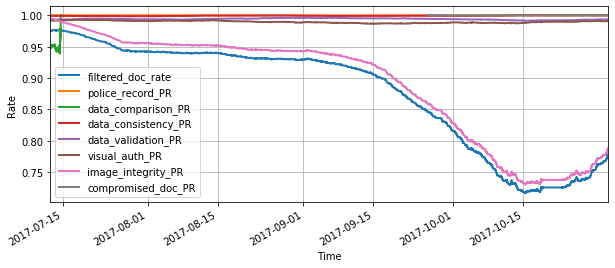

In [49]:
plt.figure()
rate_data[['filtered_doc_rate','police_record_PR','data_comparison_PR','data_consistency_PR','data_validation_PR',
          'visual_auth_PR','image_integrity_PR','compromised_doc_PR']].plot(figsize=(10,4),grid=True,
lw=2, markersize=10)
plt.xlabel("Time")
plt.ylabel("Rate")
plt.savefig('fig4.png')


#### At this stage we understand that the decrease in pass rate is entirely due to a decrease in 'Image Integrity', hence implying that the documents werent of sufficient quality to verify or that Veritas had a systemic problem for verifying the documents


#### Once again we check which factors implied in the image integrity check.
- Supported document
- Image Quality
- Colour picture
- Conclusive document quality


<Figure size 432x288 with 0 Axes>

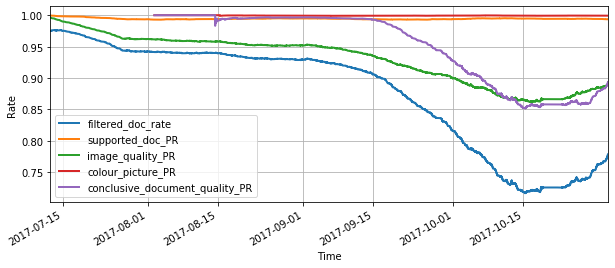

In [50]:
plt.figure()
rate_data[['filtered_doc_rate','supported_doc_PR','image_quality_PR','colour_picture_PR',
          'conclusive_document_quality_PR']].plot(figsize=(10,4),grid=True,
lw=2, markersize=10)
plt.xlabel("Time")
plt.ylabel("Rate")
plt.savefig('fig5.png')



#### We understand that the first drop in pass rate is due to the image_quality pass rate decreasing and that the second is mainly due to a decrease in the conclusive_document_quality pass rate which was not recorded before August (hence implying that the pass rate before august could have been biased)

#### At this stage we understand the root causes of the decrease in pass rate. We understand that the increase in rejected is due to an increase in image quality failure rate and that the increase in caution rate is due to an increase in the newly created conclusive_document_quality failure rate.

#### The fraud thesis can be safely rejected at this point i.e the decrease in pass rate is not due to an increase in fraudulent attempts.


#### One cause could be that there is an increase in daily KYC attempts

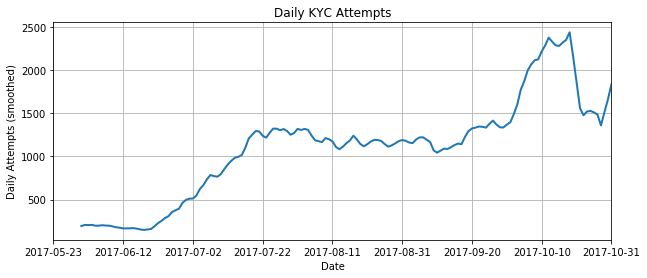

In [54]:
plt.figure()
data.groupby('created_at')['attempt_id'].count().rolling(9).mean().plot(figsize=(10,4), grid=True,
                                                                        lw=2, markersize=10)
plt.xlabel("Date")
plt.ylabel("Daily Attempts (smoothed)")
plt.title("Daily KYC Attempts")
plt.savefig('fig6.png')


#### We clearly see that there is a correlation between the two jumps in failure rate and the two jumps in daily attempts. We can infer that it is due to a hyper growth in the KYC attempts, meaning that the Veritas API has difficulties scaling and that the problem is due to an overflow.

#### We can still check if there is a correlation between the failure rate and the attempts with a certain type of document (ex passport). Other features like Gender, DoB, Date of expiry, nationality etc. are irrelevant for our goal

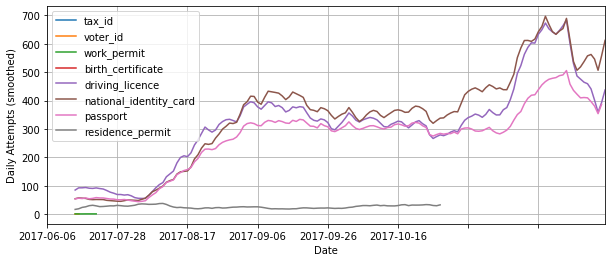

In [57]:
plt.figure()

for a in {x for x in set(data.document_type_DOC) if x==x}:
    
    data[data.document_type_DOC==a].groupby('created_at')['document_type_DOC'].count().rolling(9).mean().plot(
        figsize=(10,4),grid=True,label=a, legend=True)
    plt.xlabel("Date")
    plt.ylabel("Daily Attempts (smoothed)")
#plt.savefig('fig6.png')

#### The previous thesis is rejected as it doesnt seem like the increase in failure rate is due to a specific document as they all follow the same distribution as the global daily attempts

### Some other metrics used in the reports

Only 20% of the users that failed their first attempt cleared KYC after a second attempt

In [22]:
id_failed=data[~((data.result_FACIAL=='clear') & (data.result_DOC=='clear'))].user_id

temp=data[data.user_id.isin(id_failed)]
len(temp[(temp.result_FACIAL=='clear')&(temp.result_DOC=='clear')])/len(temp)

0.20697663244550507

Only 55% of those who failed at their first attempt tried again

In [26]:
len(temp.user_id.value_counts())/len(temp)

0.5426590002722744

0.8% attempted tried more than 2 attemps 

In [32]:
len(data.user_id.value_counts()[data.user_id.value_counts()>2])/len(data.user_id.unique())

0.008632045066001513

In [34]:
max(data.created_at)

'2017-10-31'

In [52]:
data[((data.result_FACIAL=='clear') & (data.result_DOC=='clear'))].iloc[1]

result_FACIAL                                                        clear
face_comparison_result_FACIAL                                        clear
created_at_FACIAL                                2017-06-20 17:59:49+00:00
facial_image_integrity_result_FACIAL                                 clear
score_FACIAL                                                           NaN
index_                                                                   2
user_id                                   ffb82fda52b041e4b9af9cb4ef298c85
result_DOC                                                           clear
visual_authenticity_result                                           clear
image_integrity_result_DOC                                           clear
face_detection_result_DOC                                            clear
image_quality_result_DOC                                             clear
created_at_DOC                                   2017-06-20 17:59:49+00:00
supported_document_result